In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import topojson as tp
import shapefile
import vincent

# I tried this because I hoped for resizable widgets, but it didn't work
# %matplotlib widget

In [2]:
fname = "data.csv"
if not os.path.isfile(fname):
    API = "https://ffiec.cfpb.gov/v2/data-browser-api"
    res = requests.get(f"{API}/view/csv?states=ME&years=2018&actions_taken=1,2,3,4,5")
    f = download_file(
        f"{API}/view/csv?states=ME&years=2018&actions_taken=1,2,3,4,5", fname
    )
usecols = [
    "census_tract",
    "derived_ethnicity",
    "derived_race",
    "action_taken",
    "loan_type",
    "tract_population",
    "tract_minority_population_percent",
]
loandf = pd.read_csv(
    fname,
    usecols=usecols,
)

# here's how to show the null census tract rows that blow up the int conversion:
# loandf.loc[loandf['census_tract'].isnull()]
# So, let's drop null census tract rows, they're not useful to us.
# there are 297 rows iwth null census tracts out of 54594 rows, so we should end up with 54297 rows
#
# In [181]: test = loandf.dropna(subset=['census_tract'])
#
# In [182]: test.shape
# Out[182]: (54297, 7)
loandf = loandf.dropna(subset=["census_tract"])

# census tract goes float -> drop NaN -> int -> string. Probably could be more efficient but who cares
loandf = loandf.astype({"census_tract": int}).astype({"census_tract": str})

# let's limit to loan type 1: I vaguely recall from the preso that this is the most common
loandf = loandf[loandf['loan_type'].isin([1])]

# also let's only look at actions 1 and 3 (originated and denied)
loandf = loandf[loandf['action_taken'].isin([1,3])]

loandf.head()

,census_tract,derived_ethnicity,derived_race,action_taken,loan_type,tract_population,tract_minority_population_percent
0,23005016000,Not Hispanic or Latino,White,3,1,5320,6.65
1,23017966300,Not Hispanic or Latino,American Indian or Alaska Native,1,1,3667,9.54
2,23031030201,Ethnicity Not Available,Race Not Available,3,1,3397,10.45
3,23031026000,Not Hispanic or Latino,White,1,1,4127,10.64
4,23031036001,Not Hispanic or Latino,White,1,1,7131,3.76


In [3]:
data = shapefile.Reader("maine_shapefile/cb_2018_23_tract_500k.shp")

In [4]:
topo = tp.Topology(data)

Exception ignored in: <function Reader.__del__ at 0x125c1eca0>
Traceback (most recent call last):
  File "/Users/llimllib/.pyenv/versions/3.8.5/lib/python3.8/site-packages/shapefile.py", line 981, in __del__
    self.close()
  File "/Users/llimllib/.pyenv/versions/3.8.5/lib/python3.8/site-packages/shapefile.py", line 984, in close
    for attribute in (self.shp, self.shx, self.dbf):
AttributeError: 'Reader' object has no attribute 'shp'


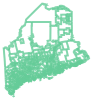

In [5]:
topo.to_svg()

In [6]:
# I'm not sure what "feature" is supposed to be, and my data doesn't have a 
# "FeatureCollection" like the vincent sample data does?
# ex: https://raw.githubusercontent.com/wrobstory/vincent_map_data/master/world-countries.json
vincent.Map(geo_data=[{'name': 'maine', 'url': 'maine.json', 'feature': 'dunno'}])

In [7]:
gdf = topo.to_gdf()
gdf = gdf.set_index("GEOID")

In [8]:
# neat! now we have a geo data frame
gdf

,geometry,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,NAME,LSAD,ALAND,AWATER
GEOID,,,,,,,,,
23005000200,"POLYGON ((-70.25105 43.66328, -70.24836 43.662...",23,005,000200,1400000US23005000200,2,CT,462934,269132
23005003000,"POLYGON ((-70.34740 43.64534, -70.37055 43.642...",23,005,003000,1400000US23005003000,30,CT,13965300,569141
23005004501,"POLYGON ((-70.16569 43.84635, -70.17138 43.840...",23,005,004501,1400000US23005004501,45.01,CT,39698051,192622
23001020300,"POLYGON ((-70.21491 44.10067, -70.21329 44.100...",23,001,020300,1400000US23001020300,203,CT,1574282,10199
23001010100,"POLYGON ((-70.23687 44.07909, -70.23569 44.077...",23,001,010100,1400000US23001010100,101,CT,880807,168955
...,...,...,...,...,...,...,...,...,...
23031036002,"POLYGON ((-70.75545 43.19650, -70.75743 43.192...",23,031,036002,1400000US23031036002,360.02,CT,111437156,5101362
23003952700,"POLYGON ((-68.43742 46.20753, -68.43637 46.183...",23,003,952700,1400000US23003952700,9527,CT,692625195,17101769
23005002001,"POLYGON ((-70.33175 43.68398, -70.32914 43.679...",23,005,002001,1400000US23005002001,20.01,CT,3328388,18533


In [9]:
# you can use as_index=False if you don't want the grouped columns to be a multiindex
sz = loandf.groupby(["census_tract", "actions_taken"]).size()
sz

census_tract  action_taken
12057013912   3                1
23001010100   1               12
              3                4
23001010200   1               58
              3               10
                              ..
25025091500   3                1
29037061400   1                1
29097011200   1                1
33003956000   3                1
33007950900   1                1
Length: 708, dtype: int64

In [10]:
# Maybe let's start simpler: let's plot the number of applications per census tract. Bigger dot = more applications
accepted = loandf[loandf['action_taken'].isin([1])].groupby(['census_tract']).size()
accepted.name="approved"
comb = pd.concat([gdf, accepted], axis=1)# gdf.join(sz, on="census_tract")

# four rows in comb don't have geometries: 25005644102, 29037061400, 29097011200, and 33007950900
# let's just drop them
comb = comb.dropna(subset=["NAME"])
comb 

,geometry,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,NAME,LSAD,ALAND,AWATER,approved
23005000200,"POLYGON ((-70.25105 43.66328, -70.24836 43.662...",23,005,000200,1400000US23005000200,2,CT,462934.0,269132.0,50.0
23005003000,"POLYGON ((-70.34740 43.64534, -70.37055 43.642...",23,005,003000,1400000US23005003000,30,CT,13965300.0,569141.0,111.0
23005004501,"POLYGON ((-70.16569 43.84635, -70.17138 43.840...",23,005,004501,1400000US23005004501,45.01,CT,39698051.0,192622.0,94.0
23001020300,"POLYGON ((-70.21491 44.10067, -70.21329 44.100...",23,001,020300,1400000US23001020300,203,CT,1574282.0,10199.0,42.0
23001010100,"POLYGON ((-70.23687 44.07909, -70.23569 44.077...",23,001,010100,1400000US23001010100,101,CT,880807.0,168955.0,12.0
...,...,...,...,...,...,...,...,...,...,...
23031036002,"POLYGON ((-70.75545 43.19650, -70.75743 43.192...",23,031,036002,1400000US23031036002,360.02,CT,111437156.0,5101362.0,204.0
23003952700,"POLYGON ((-68.43742 46.20753, -68.43637 46.183...",23,003,952700,1400000US23003952700,9527,CT,692625195.0,17101769.0,28.0
23005002001,"POLYGON ((-70.33175 43.68398, -70.32914 43.679...",23,005,002001,1400000US23005002001,20.01,CT,3328388.0,18533.0,74.0
23001010500,"POLYGON ((-70.23423 44.08008, -70.23223 44.080...",23,001,010500,1400000US23001010500,105,CT,778737.0,92987.0,19.0


<AxesSubplot:>

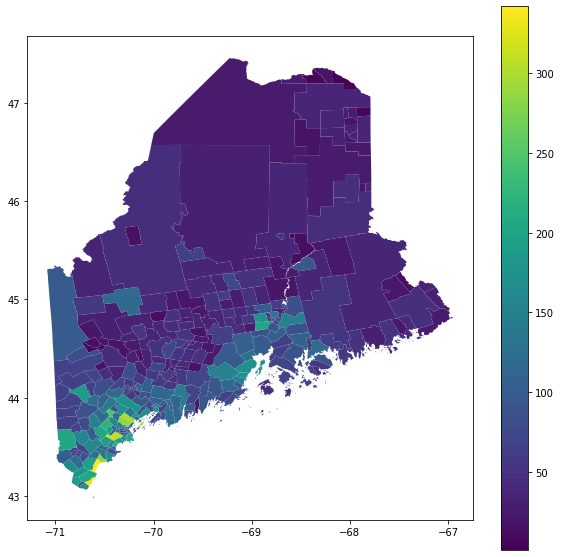

In [11]:
comb.plot("approved", legend=True, figsize=(10,10))

<AxesSubplot:>

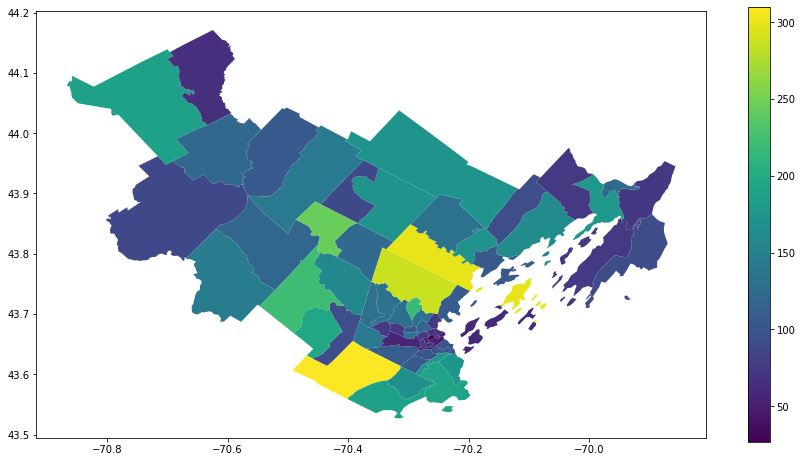

In [17]:
# limit to cumberland county
cumberland = comb[comb["COUNTYFP"] == "005"]
cumberland.plot("approved", legend=True, figsize=(15,8))

<AxesSubplot:>

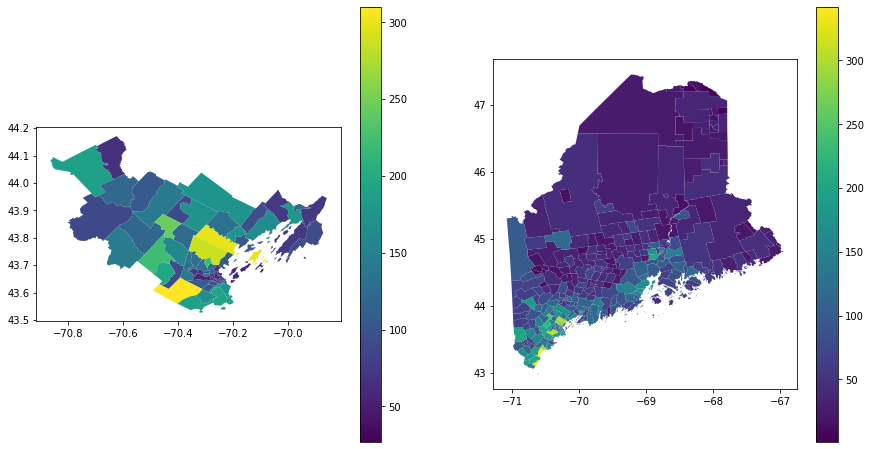

In [20]:
# just generally figuring out how subplots work
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
cumberland.plot("approved", legend=True, ax=ax[0])
comb.plot("approved", legend=True, ax=ax[1])


In [141]:
minority = loandf.groupby(["census_tract", "tract_minority_population_percent"]) \
    .first() \
    .reset_index(level="tract_minority_population_percent")
minority = pd.concat([gdf, minority], axis=1)

# again there are somehow out of state tract IDs in here, drop them
minority = minority.dropna(subset=["NAME","tract_minority_population_percent"])
minority
# mingeo = pd.concat([gdf, minority], axis=1)

,geometry,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,NAME,LSAD,ALAND,AWATER,tract_minority_population_percent,derived_ethnicity,derived_race,action_taken,loan_type,tract_population
23005000200,"POLYGON ((-70.25105 43.66328, -70.24836 43.662...",23,005,000200,1400000US23005000200,2,CT,462934.0,269132.0,8.27,Not Hispanic or Latino,White,3.0,1.0,2515.0
23005003000,"POLYGON ((-70.34740 43.64534, -70.37055 43.642...",23,005,003000,1400000US23005003000,30,CT,13965300.0,569141.0,12.68,Not Hispanic or Latino,White,3.0,1.0,6693.0
23005004501,"POLYGON ((-70.16569 43.84635, -70.17138 43.840...",23,005,004501,1400000US23005004501,45.01,CT,39698051.0,192622.0,10.10,Joint,White,1.0,1.0,3079.0
23001020300,"POLYGON ((-70.21491 44.10067, -70.21329 44.100...",23,001,020300,1400000US23001020300,203,CT,1574282.0,10199.0,23.41,Ethnicity Not Available,Race Not Available,3.0,1.0,6574.0
23001010100,"POLYGON ((-70.23687 44.07909, -70.23569 44.077...",23,001,010100,1400000US23001010100,101,CT,880807.0,168955.0,22.43,Not Hispanic or Latino,White,3.0,1.0,1725.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23031036002,"POLYGON ((-70.75545 43.19650, -70.75743 43.192...",23,031,036002,1400000US23031036002,360.02,CT,111437156.0,5101362.0,2.04,Ethnicity Not Available,Race Not Available,1.0,1.0,5586.0
23003952700,"POLYGON ((-68.43742 46.20753, -68.43637 46.183...",23,003,952700,1400000US23003952700,9527,CT,692625195.0,17101769.0,4.07,Ethnicity Not Available,Race Not Available,1.0,1.0,2553.0
23005002001,"POLYGON ((-70.33175 43.68398, -70.32914 43.679...",23,005,002001,1400000US23005002001,20.01,CT,3328388.0,18533.0,20.37,Not Hispanic or Latino,White,3.0,1.0,3652.0
23001010500,"POLYGON ((-70.23423 44.08008, -70.23223 44.080...",23,001,010500,1400000US23001010500,105,CT,778737.0,92987.0,12.82,Not Hispanic or Latino,White,1.0,1.0,2082.0


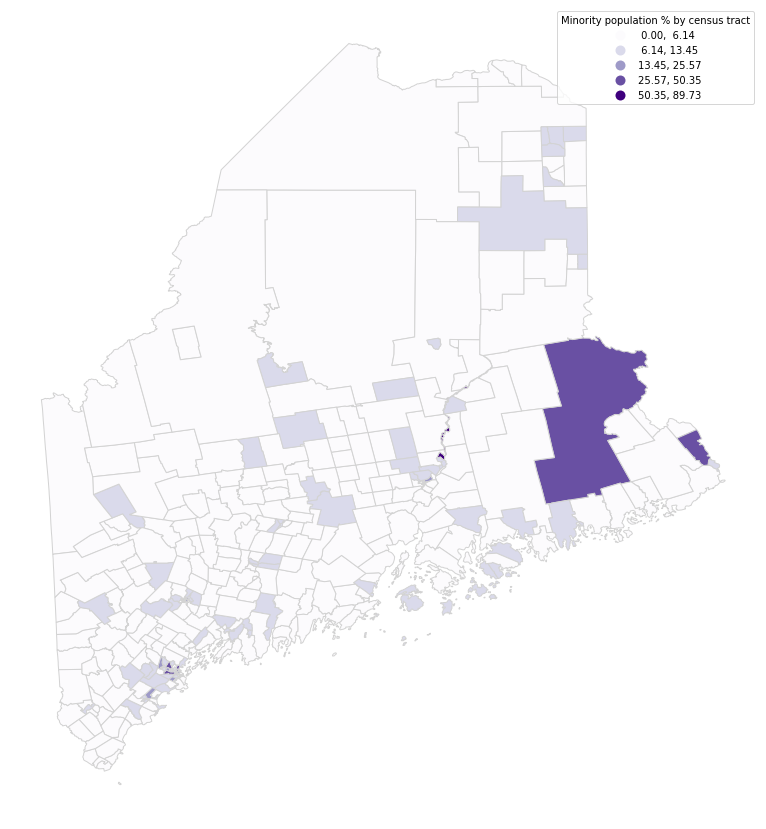

In [114]:
# this doesn't seem very likely? But maybe the big area is a native american reservation(s)?
fig, ax = plt.subplots(1, 1, figsize=(15,15), facecolor='white')
ax.axis('off')

ax = minority.plot("tract_minority_population_percent", 
              legend=True, 
              figsize=(10,10), 
              scheme='NaturalBreaks',
              ax=ax,
              cmap='Purples', 
              edgecolor="lightgrey")
ax.get_legend().set_title("Minority population % by census tract")

fig.savefig("map.png")

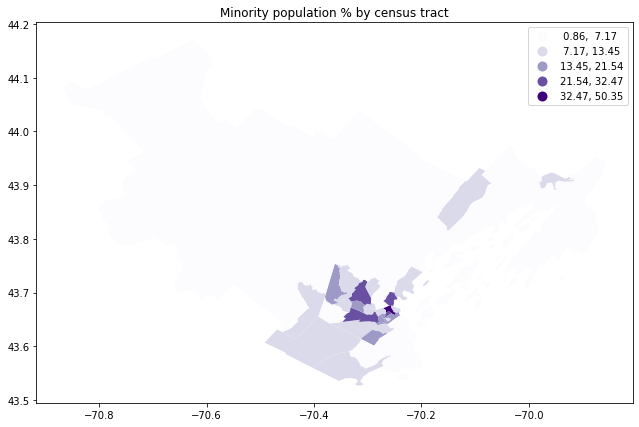

In [115]:
cumbmin = minority[minority["COUNTYFP"] == "005"]
fig, ax = plt.subplots(1, 1, figsize=(12,7))
ax.set_title('Minority population % by census tract')
ax = cumbmin.plot("tract_minority_population_percent", 
             legend=True, 
             scheme='NaturalBreaks',
             ax=ax,
             cmap='Purples')
             # title='Minority population % by census tract')

<AxesSubplot:>

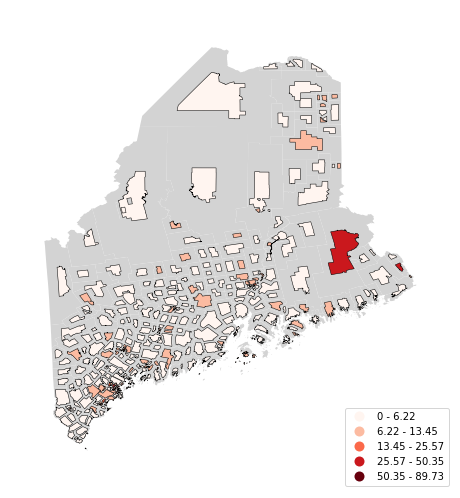

In [144]:
import geoplot
import mapclassify as mc

scheme = mc.NaturalBreaks(minority["tract_minority_population_percent"], k=5)
ax = geoplot.cartogram(minority, scale='tract_population', 
                       limits=(0.25, 1),
    #projection=geoplot.crs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5),
    hue='tract_minority_population_percent', cmap='Reds', scheme=scheme,
    linewidth=0.5,
    legend=True, legend_kwargs={'loc': 'lower right'}, legend_var='hue',
    figsize=(8, 12)
)
geoplot.polyplot(minority, facecolor='lightgray', edgecolor='None', ax=ax)


In [139]:
minority[minority['tract_minority_population_percent'].isnull()]

KeyError: '23031990100'